In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random
from jax.lax import fori_loop
from utils import ard, squared_distance_matrix
from jax.ops import index, index_add, index_update
import matplotlib.pyplot as plt
import time

In [2]:
from svgd import update

# Build the class

In [3]:
from svgd import SVGD, get_bandwidth

# Now test it

In [5]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

print('logp is located at', hex(id(logp)))

logp is located at 0x7f0e42fa4d90


In [6]:
n = 100
d = 1
stepsize = 0.01
L = 1000

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,1)) - 10

h = 1
print('h is located at', hex(id(h))) # memory location

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


h is located at 0xa68ac0


## Fixed bandwidth parameter

In [7]:
svgd = SVGD(logp, n_iter=L, adaptive_kernel=False, get_bandwidth=None)

In [17]:
st = time.time()
xout, log = svgd.svgd(x0, stepsize, bandwidth=h)
xout.block_until_ready()
el = time.time() - st
print("elapsed time:", el)

elapsed time: 0.21372389793395996


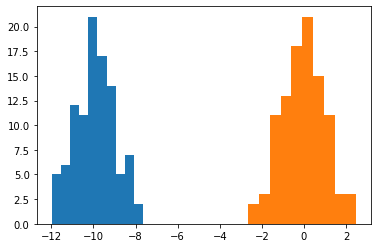

In [9]:
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout[:, 0])

More rigorous timing:

In [10]:
%%timeit
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10
xoutf, log = svgd.svgd(x0, stepsize, h)
xoutf.block_until_ready()

177 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Adaptive bandwidth parameter

In [11]:
svgd_adaptive = SVGD(logp, n_iter=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [12]:
svgd_adaptive.get_bandwidth(x0)

DeviceArray([0.17484881], dtype=float32)

In [13]:
st = time.time()
xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0) # bandwidth para should not matter
xout.block_until_ready()
el = time.time() - st
print("elapsed time:", el)

elapsed time: 66.02540516853333


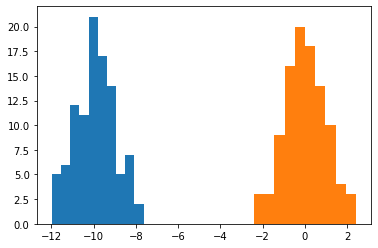

In [14]:
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout[:, 0])

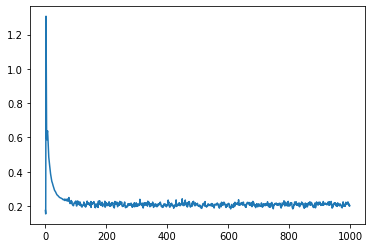

In [15]:
plt.plot(log["bandwidth"])

More rigorous timing:

In [18]:
%%timeit
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10
xouta, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0)
xouta.block_until_ready()

2.24 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
